<a href="https://colab.research.google.com/github/AnishaA-git/Fake-News-Spam/blob/master/Final_HW_8_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Week 8

Article: https://link.springer.com/content/pdf/10.1007/s40747-021-00552-1.pdf


**Dataset:**
 1. Fake News dataset <br>(https://www.kaggle.com/manasvik/spam-check/data)
 2. GoogleNews API dataset

### Process
- Load the Data (Fake News Dataset)
- Distillation Process
    - Data Cleaning and Text Preprocessing
    - Visualization

Features Added:
- **Feature 1 :** Word Frequency
- **Feature 2 :** Readability Score

Content Based:
- **Micro Factor 1 :** Profanity Check
- **Micro Factor 2 :** Parts of Speech Adjectives
- **Micro Factor 3 :** Parts of Speech Adverbs


#### Enrichment Dataset Details
- LDA Topic Modeling
- PoliticalFact Fake news and Real News Content 
- Bag of Words
- Spam Dictionary 



In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from plotly.offline import *
import plotly
import io
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from nltk.corpus import stopwords
from string import punctuation
from scipy import sparse
from wordcloud import WordCloud, STOPWORDS
from scipy import stats
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **Fake News Data Set**

# **DATA IMPORTING**

In [2]:
# Kaggle Fake news dataset
url="https://media.githubusercontent.com/media/AnishaA-git/Fake-News-Spam/master/fake.csv"
file=requests.get(url).content
fake_news=pd.read_csv(io.StringIO(file.decode('utf-8')),sep=',')

In [3]:
print(fake_news.shape)

(12999, 20)


In [4]:
print(fake_news.describe())
fake_news.head()

       ord_in_thread   domain_rank  ...      comments        shares
count   12999.000000   8776.000000  ...  12999.000000  12999.000000
mean        0.891530  38092.996582  ...      0.038311     10.831833
std         6.486822  26825.487454  ...      0.827335     79.798949
min         0.000000    486.000000  ...      0.000000      0.000000
25%         0.000000  17423.000000  ...      0.000000      0.000000
50%         0.000000  34478.000000  ...      0.000000      0.000000
75%         0.000000  60570.000000  ...      0.000000      0.000000
max       100.000000  98679.000000  ...     65.000000    988.000000

[8 rows x 8 columns]


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


# **DATA PRE-PROCESSING**

In [5]:
column_names = list(fake_news.columns)
print(column_names)
for column in column_names:
    if fake_news[column].count()<len(fake_news):
        print(column,fake_news[column].count())     
        
fake_news.loc[fake_news['text'].isnull(),'text'] = 'unknown'
fake_news.loc[fake_news['country'].isnull(),'country'] = 'US' 
fake_news.loc[fake_news['author'].isnull(),'author'] = fake_news.loc[fake_news['author'].isnull(),'country']
fake_news.loc[fake_news['thread_title'].isnull(),'thread_title'] = ''
fake_news.loc[fake_news['domain_rank'].isnull(),'domain_rank'] = np.nanmedian(np.array(fake_news['domain_rank'])) 

['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'thread_title', 'spam_score', 'main_img_url', 'replies_count', 'participants_count', 'likes', 'comments', 'shares', 'type']
author 10575
title 12319
text 12953
country 12823
domain_rank 8776
thread_title 12987
main_img_url 9356


Since features play a BIG role in the prediction accuracy I will be using the following features:

1. From tweet text
*   number of words
*   similarity score between tweet text and title of URL (using tfidf)
2. From tweet metadata
*   Author name
*   likes
*   comments
*   shares
*   replies_count
*   country
*   participants_count
*   domain_rank
*   language


# Adding Feature 1 - Word Count

In [6]:
# starting with features from tweet content

pstem = PorterStemmer()
stop = set(stopwords.words('english'))

def stemmer(text):
    wordlist = text.strip().split()
    pstem = PorterStemmer()
    j = '';
    for word in wordlist:
        try:
            j = j+pstem.stem(word)+' '
        except: 
            print(text)
    return j

#converting all texts and thread_titles to lowercase
fake_news['clean_text'] = fake_news['text'].map(lambda x: re.sub(r'[^a-z ]','',x.lower()))
fake_news['clean_text'] = fake_news['clean_text'].map(lambda x: ' '.join([word for word in x.strip().split() if word not in stop ]))
fake_news['clean_text'] = fake_news['clean_text'].map(lambda x: stemmer(x))
fake_news['clean_thread'] = fake_news['thread_title'].map(lambda x: re.sub(r'[^a-z ]','',x.lower()))
fake_news['clean_thread'] = fake_news['clean_thread'].map(lambda x: ' '.join([word for word in x.strip().split() if word not in stop ]))
fake_news['clean_thread'] = fake_news['clean_thread'].map(lambda x: ' '.join([pstem.stem(word) for word in x.strip().split()]))

#feature1- number of words
fake_news['num_words'] = fake_news['clean_text'].map(lambda x: len(str(x).strip().split()))

# **TF-IDF & SIMILARITY**

In [7]:
#feature2 - similarity score between tweet text and title 
def similarity(t1,t2):
    t = [t1,t2]
    tfidf_vectorizer = TfidfVectorizer()
    try:
        vectors = tfidf_vectorizer.fit_transform(t)
        vectors = vectors.toarray()
        sim = cosine_similarity(vectors[0].reshape(1,-1),vectors[1].reshape(1,-1))[0]
    except:
        sim = 0
    return sim

fake_news['similarity'] = [similarity(b['clean_text'],b['clean_thread']) for (a,b) in fake_news.iterrows()]
fake_news['similarity'].describe() 

count    12999.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: similarity, dtype: float64

In [8]:
fake_news['index'] = fake_news.index
data = fake_news
train_lda = data[['clean_text', 'index','clean_thread']]
train_lda.head(4)

,clean_text,index,clean_thread
0,print pay back money plu interest entir famili...,0,muslim bust stole million govt benefit
1,attorney gener loretta lynch plead fifth barra...,1,attorney gener loretta lynch plead fifth
2,red state fox news sunday report morn anthoni ...,2,break weiner cooper fbi hillari email investig
3,email kayla mueller prison tortur isi chanc re...,3,pin drop speech father daughter kidnap kill is...


In [9]:
processed_docs = train_lda['clean_text'].map(lambda doc: doc.split(" "))
processed_docs[:4]

0    [print, pay, back, money, plu, interest, entir...
1    [attorney, gener, loretta, lynch, plead, fifth...
2    [red, state, fox, news, sunday, report, morn, ...
3    [email, kayla, mueller, prison, tortur, isi, c...
Name: clean_text, dtype: object

# Adding Feature 2- Readability Score

In [10]:
!pip install readability

In [11]:
import readability
count=0
readability_list = []
final_list = []
txt = fake_news['clean_text']
for i in txt:
  if not i.strip():
    final_list.append(0)
  else:
    results = readability.getmeasures(i, lang='en')
    readability_list = results['readability grades']['FleschReadingEase']
    final_list.append(readability_list)
fake_news['readability_score'] = final_list

# **LDA TOPIC MODELLING**

In [12]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = fake_news['clean_text'].map(get_word_tokens)

In [13]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('Dictionary Words and Maximum occurences')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

In [14]:

def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n BOW Vector First Item')
    print(bow_doc_local_0)
    print('\n Preview BOW')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

In [15]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n TF-IDF Vector First Item')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

In [16]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

In [17]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [18]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

In [19]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [20]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(fake_news,'clean_text')

Dictionary Words and Maximum occurences
0 
1 anoth
2 asap
3 back
4 benefit
5 bust
6 came
7 case
8 commit
9 control
10 deport

 BOW Vector First Item
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (39, 1), (40, 1)]

 Preview BOW
Word 0 ("anoth") appears 1 time.
Word 1 ("asap") appears 1 time.
Word 2 ("back") appears 1 time.
Word 3 ("benefit") appears 1 time.
Word 4 ("bust") appears 1 time.
Word 5 ("came") appears 1 time.
Word 6 ("case") appears 1 time.
Word 7 ("commit") appears 1 time.
Word 8 ("control") appears 1 time.
Word 9 ("deport") appears 1 time.
Word 10 ("entir") appears 1 time.
Word 11 ("everyon") appears 1 time.
Word 12 ("famili") appears 1 time.
Word 13 ("four") appears 1 time.
Word 14 ("fraud") appears 1 time.
Word 16 ("govern") 

In [21]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['clinton', 'email', 'investig', 'state', 'report', 'hillari', 'said', 'comey', 'time', 'would']
1::['clinton', 'trump', 'hillari', 'presid', 'email', 'would', 'campaign', 'state', 'elect', 'obama']
2::['trump', 'vote', 'elect', 'peopl', 'state', 'clinton', 'democrat', 'american', 'hillari', 'said']
3::['russia', 'state', 'syria', 'would', 'govern', 'presid', 'countri', 'russian', 'said', 'peopl']
4::['govern', 'peopl', 'state', 'pipelin', 'would', 'said', 'american', 'like', 'year', 'attack']
5::['para', 'russian', 'email', 'state', 'como', 'clinton', 'russia', 'would', 'said', 'peopl']
6::['like', 'state', 'american', 'make', 'trump', 'peopl', 'time', 'news', 'world', 'media']
7::['state', 'obama', 'govern', 'would', 'peopl', 'year', 'presid', 'world', 'nation', 'american']
8::['peopl', 'world', 'state', 'time', 'nation', 'like', 'would', 'year', 'govern', 'said']
9::['peopl', 'time', 'like', 'year', 'also', 'mani', 'said', 'make', 'world', 'even']


In [22]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 TF-IDF Vector First Item
[(0, 0.08275387447287372),
 (1, 0.34732052969890836),
 (2, 0.07326793123378836),
 (3, 0.146331237598883),
 (4, 0.25694326941888074),
 (5, 0.11662671651052897),
 (6, 0.09549975200972269),
 (7, 0.13631871057630102),
 (8, 0.10015156364799924),
 (9, 0.2379558140945087),
 (10, 0.11149877411061139),
 (11, 0.12770346764229712),
 (12, 0.11049626377938052),
 (13, 0.12894216192330096),
 (14, 0.16855163938296797),
 (16, 0.1459631358268953),
 (17, 0.18387168545296842),
 (18, 0.09728486080549911),
 (19, 0.04477612682794822),
 (20, 0.09446475108984374),
 (21, 0.11242309807054697),
 (22, 0.0991542140769561),
 (23, 0.1610887765005904),
 (24, 0.0722250290867347),
 (25, 0.172930134785294),
 (28, 0.15824510936044836),
 (29, 0.10483182972694496),
 (30, 0.06246753942894103),
 (31, 0.25567781643453247),
 (32, 0.354172583742926),
 (33, 0.1941392224492906),
 (34, 0.2811175996848103),
 (35, 0.06038995036960375),
 (36, 0.21971785906891358),
 (39, 0.157161265715028),
 (40, 0.0514319320

In [23]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['para', 'email', 'clinton', 'como', 'estado', 'president', 'investig', 'comey', 'hillari', 'abedin']
1::['clinton', 'trump', 'gold', 'elect', 'tesla', 'period', 'bundi', 'bank', 'sich', 'hillari']
2::['text', 'italiano', 'result', 'insur', 'premium', 'trump', 'obamacar', 'gold', 'automat', 'percent']
3::['russia', 'syria', 'russian', 'pipelin', 'militari', 'govern', 'syrian', 'forc', 'state', 'dakota']
4::['trump', 'clinton', 'hillari', 'vote', 'elect', 'obama', 'presid', 'campaign', 'peopl', 'donald']
5::['wearechang', 'vote', 'voter', 'elect', 'pravda', 'poll', 'trump', 'clinton', 'malik', 'video']
6::['email', 'clinton', 'comey', 'investig', 'abedin', 'weiner', 'huma', 'server', 'unknown', 'hillari']
7::['cancer', 'food', 'eddi', 'water', 'research', 'bodi', 'studi', 'health', 'anim', 'kelli']
8::['sermon', 'agre', 'chin', 'podesta', 'fifteen', 'walsh', 'marina', 'pastor', 'corbyn', 'kadzik']
9::['pravdaru', 'facebook', 'convers', 'sourc', 'comment', 'garner', 'liar', 'documenta

In [24]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

In [25]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
fake_newss = update_lda_results_to_dataset(
    fake_news, headlinetopiccolnames,'clean_text', dictionary_headline, lda_model_headline, lda_headline_topic_words)
fake_newss.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_score,topic_number,lda_score,topic_top_words
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,18.531957,7,0.550067,state obama govern would peopl year presid wor...
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,-115.928659,0,0.968589,clinton email investig state report hillari sa...
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,-74.141154,0,0.991962,clinton email investig state report hillari sa...
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,43.206897,1,0.954990,clinton trump hillari presid email would campa...
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,-155.693776,2,0.519066,trump vote elect peopl state clinton democrat ...


In [26]:
train_data, validate_data, test_data = np.split(fake_newss.sample(frac=1), [int(.6*len(fake_newss)), int(.8*len(fake_newss))])

train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Size of training set: {}".format(len(train_data)))
print("Size of validation set: {}".format(len(validate_data)))
print("Size of testing set: {}".format(len(test_data)))

Size of training set: 7799
Size of validation set: 2600
Size of testing set: 2600


In [27]:
train_data.head(3)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_score,topic_number,lda_score,topic_top_words
0,c77d01682e01c3321fa7bbbfb69fdf83fe60c17e,0,SUPREMEMASTER,2016-10-26T16:40:00.000+03:00,Babylon Mystery Religion Series,"Part 1 BABYLON ""SUN WORSHIP"" https://www.youtu...",english,2016-10-27T17:53:23.982+03:00,prisonplanet.com,US,41475.0,Babylon Mystery Religion Series,0.0,NaN,6,3,0,0,0,conspiracy,part babylon sun worship httpswwwyoutubecomwat...,babylon mysteri religion seri,5,0,7684,-35.120000,8,0.774973,peopl world state time nation like would year ...
1,1c169a0834f735e53eab4206a4a54a1d9fdf0130,0,BareNakedIslam,2016-11-03T12:07:00.000+02:00,Louis Farrakhan (Nation of Islam) agrees with ...,"November 3, 2016 @ 3:07 am \nAllowing any GdM ...",english,2016-11-03T12:47:01.586+02:00,barenakedislam.com,US,61606.0,Louis Farrakhan (Nation of Islam) agrees with ...,0.0,http://img.youtube.com/vi/L2itYutAuc4/0.jpg,0,1,0,0,0,bs,novemb allow gdm enter remain suicid vet musli...,loui farrakhan nation islam agre donald trump ...,82,0,1072,-24.960854,8,0.348114,peopl world state time nation like would year ...
2,87d188df4c457b9cc3f2ac4ce03d5e56cc9a7a2b,0,noreply@blogger.com (Alexander Light),2016-11-07T05:37:13.077+02:00,"This Ginger Tea Recipe Cleanses the Liver, Dis...",". This Ginger Tea Recipe Cleanses the Liver, D...",english,2016-11-07T05:37:13.077+02:00,humansarefree.com,US,60463.0,"This Ginger Tea Recipe Cleanses the Liver, Dis...",0.0,https://1.bp.blogspot.com/-cNBaTaw-CbY/WB72-Tf...,0,1,0,0,0,bs,ginger tea recip cleans liver dissolv kidney s...,ginger tea recip cleans liver dissolv kidney s...,115,0,4434,-68.790870,9,0.990998,peopl time like year also mani said make world...


# BoW's

In [28]:
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')

fake_news = fake_newss[fake_newss["type"] == "fake"]

# Join the title and text
all_text = fake_news.title.str.cat(fake_news.text, sep=' ')

# Tokenize. The NLTK tokenizer isn't awesome. Spacy has a nice one, but I don't think it is installed
words = nltk.word_tokenize(" ".join(all_text.tolist()))

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('english') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


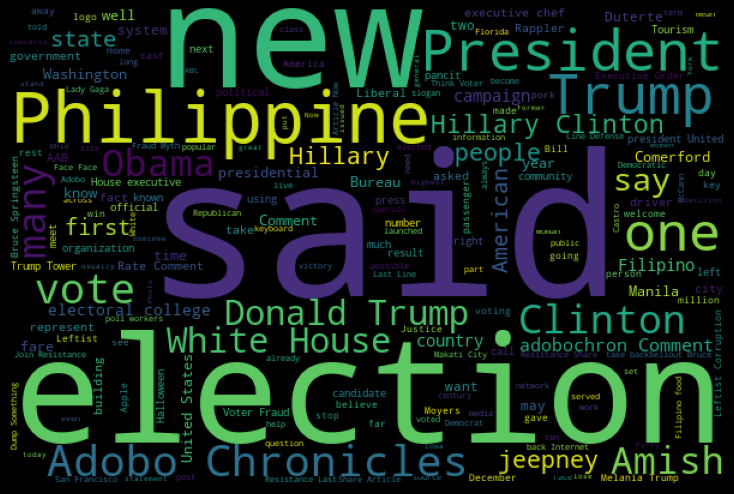

In [29]:
from wordcloud import WordCloud, STOPWORDS

# Generate a word cloud image
fake_wordcloud = WordCloud(width=600, height=400).generate(" ".join(cleanwords))

#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(fake_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [30]:
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')

fake_news = fake_newss[fake_newss["type"] == "bias"]

# Join the title and text
all_text = fake_news.title.str.cat(fake_news.text, sep=' ')
all_text = all_text.astype(str)
# Tokenize. The NLTK tokenizer isn't awesome. Spacy has a nice one, but I don't think it is installed
words = nltk.word_tokenize(" ".join(all_text.tolist()))

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('english') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


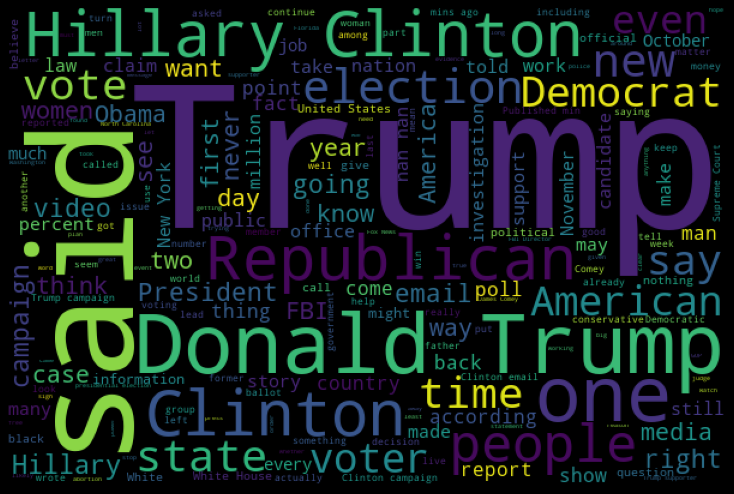

In [31]:
from wordcloud import WordCloud, STOPWORDS

# Generate a word cloud image
bias_wordcloud = WordCloud(width=600, height=400).generate(" ".join(cleanwords))

#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(bias_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [32]:
bigrams = nltk.bigrams(cleanwords)

In [33]:
# look at the most common. 

from collections import Counter
counter = Counter(bigrams)
print(counter.most_common(10))

[(('Donald', 'Trump'), 393), (('Hillary', 'Clinton'), 338), (('New', 'York'), 88), (('nan', 'nan'), 82), (('White', 'House'), 74), (('United', 'States'), 74), (('Clinton', 'campaign'), 73), (('Supreme', 'Court'), 72), (('Published', 'mins'), 63), (('mins', 'ago'), 63)]


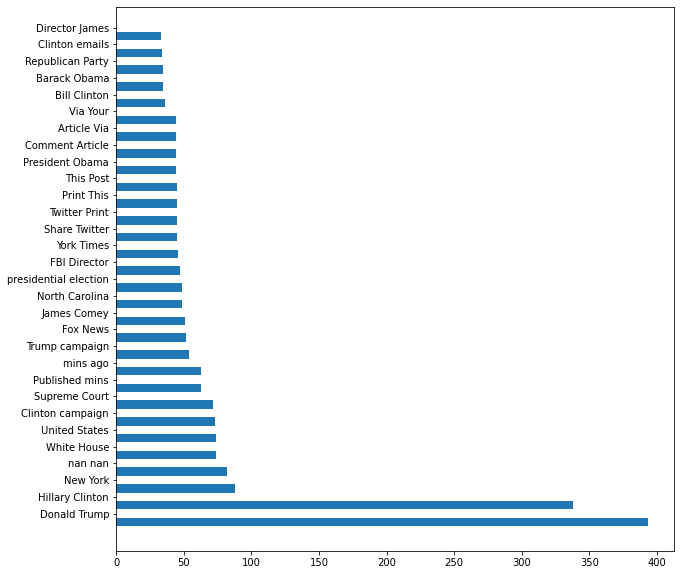

In [34]:
num_to_show = 30

labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
values = [e[1] for e in counter.most_common(num_to_show)]

indexes = np.arange(len(labels))
width = 0.5

#plt.bar(indexes, values, width)
#plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.figure(figsize=(10,10))
plt.barh(indexes, values, width)
plt.yticks(indexes + width, labels)

plt.show()

# Micro Factor 1 - Profanity Check

In [35]:
!pip install profanity-check

In [36]:
!pip install --upgrade scikit-learn==0.22.1

In [37]:
# import joblib
from profanity_check import predict, predict_prob


def check_profanity(fake_newss):
  fake_newss['contains_profanity'] = predict(fake_newss['clean_text'])
  return fake_newss

fake_newss = check_profanity(fake_newss)
fake_newss

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.

/usr/

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_score,topic_number,lda_score,topic_top_words,contains_profanity
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,18.531957,7,0.550067,state obama govern would peopl year presid wor...,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,-115.928659,0,0.968589,clinton email investig state report hillari sa...,0
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,-74.141154,0,0.991962,clinton email investig state report hillari sa...,0
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,43.206897,1,0.954990,clinton trump hillari presid email would campa...,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,-155.693776,2,0.519066,trump vote elect peopl state clinton democrat ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,110.055000,6,0.887474,like state american make trump peopl time news...,1
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,wait till see happen valuat r

In [38]:
result = fake_newss[(fake_newss['contains_profanity']  == 1)]
result

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_score,topic_number,lda_score,topic_top_words,contains_profanity
5,8f30f5ea14c9d5914a9fe4f55ab2581772af4c31,0,Barracuda Brigade,2016-11-02T16:31:28.550+02:00,Hillary Goes Absolutely Berserk On Protester A...,Print Hillary goes absolutely berserk! She exp...,english,2016-11-02T16:31:28.550+02:00,100percentfedup.com,US,25689.0,Hillary Goes Absolutely Berserk On Protester A...,0.0,http://bb4sp.com/wp-content/uploads/2016/11/Fu...,0,1,0,0,0,bias,print hillari goe absolut berserk explod bill ...,hillari goe absolut berserk protest ralli video,121,0,5,-76.090744,1,0.990720,clinton trump hillari presid email would campa...,1
22,ee8e9d4d80c9b05f5a049f6687be1cf8a90cdc34,0,EdJenner,2016-11-15T09:43:45.343+02:00,WOW! WHITE Liberals Suggest Blacks Are Too Stu...,Go to Article Filmmaker Ami Horowitz takes to ...,english,2016-11-15T09:43:45.343+02:00,100percentfedup.com,US,25689.0,WOW! WHITE Liberals Suggest Blacks Are Too Stu...,0.0,http://conservativeangle.com/wp-content/upload...,0,1,0,0,0,bias,go articl filmmak ami horowitz take street ber...,wow white liber suggest black stupid get idsca...,53,0,22,20.553208,2,0.767843,trump vote elect peopl state clinton democrat ...,1
29,5c96dddf3e19affb7386519985180b9e086bea93,0,Barracuda Brigade,2016-11-23T21:54:00.000+02:00,BOOM! Kellyanne Conway Shuts Down CNN’s Cuomo,BOOM! Kellyanne Conway Shuts Down CNN’s Cuomo ...,english,2016-11-24T01:18:15.204+02:00,100percentfedup.com,US,25689.0,BOOM! Kellyanne Conway Shuts Down CNN’s Cuomo,0.0,http://bb4sp.com/wp-content/uploads/2016/11/Fu...,0,1,0,0,0,bias,boom kellyann conway shut cnn cuomo barracuda ...,boom kellyann conway shut cnn cuomo,35,0,29,26.281429,2,0.642019,trump vote elect peopl state clinton democrat ...,1
109,e7aacfabf3903ed68a5aa056c098f2face98cee8,0,tokyowashi (noreply@blogger.com),2016-10-31T02:03:09.291+02:00,"Do Not Forgive the MSM; Alt-Media, Our Job Is ...",Jimstone.is \nOctober 29 2016 \n\nDO NOT FORGI...,english,2016-10-31T02:03:09.291+02:00,abeldanger.net,US,34478.0,"Do Not Forgive the MSM; Alt-Media, Our Job Is ...",0.0,NaN,0,1,0,0,0,bs,jimstonei octob forgiv msm msm turn hillari fb...,forgiv msm altmedia job,714,0,109,-656.979202,1,0.453558,clinton trump hillari presid email would campa...,1
147,e479b6959d80b6f3b934de0a24c71ab7a9e0f440,1,Steve smith,2016-11-01T22:22:00.000+02:00,NaN,Google David Howard......Uh oh! Google Me........,english,2016-11-02T03:48:46.543+02:00,abeldanger.net,US,34478.0,Insiders Threaten to Expose Hillary's Pedophil...,0.0,NaN,6,1,0,0,0,bs,googl david howarduh oh googl meuh oh googl th...,insid threaten expos hillari pedophil sex ring,16,0,147,63.695000,6,0.909985,like state american make trump peopl time news...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12970,2e757d8576f6875f1088c3cbf32eb98da1caf0d4,15,gatorengineer,2016-10-27T00:37:44.486+03:00,NaN,more like a burning bag of shit on a doorstep....,english,2016-10-27T00:37:44.486+03:00,zerohedge.com,US,2435.0,Tesla Earnings Smash Expectations After Dramat...,0.0,NaN,26,24,0,0,0,bs,like burn bag shit doorstep,tesla earn smash expect dramat chang report me...,5,0,12970,100.240000,4,0.819962,govern peopl state pipelin would said american...,1
12972,46b5ff68beda3548cc288567159bd780cfd674ee,17,besnook,2016-10-27T00:35:00.000+03:00,NaN,non gaap has always been bullshit.,english,2016-10-27T00:37:44.567+03:00,zerohedge.com,US,2435.0,Tesla Earnings Smash Expectations After Dramat...,0.0,NaN,26,24,0,0,0,bs,non gaap alway bullshit,tesla earn smash expect dramat chang report me...,4,0,12972,75.875000,4,0.699934,govern peopl state pipelin would said american...,1
12981,e6a50424ffbdb786f2630b32a31675a9093772ba,26,starman,2016-10-27T00:3

In [39]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


# Micro Factor 2 & 3 - POS- Adjective and Adverbs

In [40]:
from textblob import TextBlob
from collections import Counter
txt = fake_newss['clean_text']
count = 0
adj_list = []
adv_list = []
final_list_adj = []
final_list_adv = []
def textblob_adj(text):
  blobed = TextBlob(text)
  # counts = Counter(tag for word,tag in blobed.tags)
  adj_list = []
  adv_list = []
  adj_tag_list = ['JJ','JJR','JJS']
  adv_tag_list = ['RB','RBR','RBS']
  for (a, b) in blobed.tags:
      if b in adj_tag_list:
          adj_list.append(a)
      elif b in adv_tag_list:
          adv_list.append(a)
      else:
          pass
  return adj_list, adv_list

for i in txt:
  adj_list, adv_list = textblob_adj(i)
  if not adj_list:
    final_list_adj.append(0)
  else:
    final_list_adj.append(1)
  if not adv_list:
    final_list_adv.append(0)
  else:
    final_list_adv.append(1)
  # final_list_adj.append(adj_list)
  # final_list_adv.append(adv_list)

fake_newss['adjective'] = final_list_adj
fake_newss['adverb'] = final_list_adv
fake_newss

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_score,topic_number,lda_score,topic_top_words,contains_profanity,adjective,adverb
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,18.531957,7,0.550067,state obama govern would peopl year presid wor...,0,1,1
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,-115.928659,0,0.968589,clinton email investig state report hillari sa...,0,1,1
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,-74.141154,0,0.991962,clinton email investig state report hillari sa...,0,1,1
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,43.206897,1,0.954990,clinton trump hillari presid email would campa...,0,1,1
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,-155.693776,2,0.519066,trump vote elect peopl state clinton democrat ...,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,110.055000,6,0.887474,like state american make trump peopl time news...,1,1,1
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000

# PipeLine Models For Different Classifiers - Micro Factor 3 - Adverbs

In [45]:
X_adv = fake_newss['clean_text']
y_adv = fake_newss['adverb']
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_adv)
X_vec_adv = vect.transform(X_adv)
len(vect.get_feature_names())

160439

In [48]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_vec_adv, y_adv, test_size=0.1, random_state = 0)

print(X_train_adv.shape)
print(X_test_adv.shape)
print(y_train_adv.shape)
print(y_test_adv.shape)

(11699, 160439)
(1300, 160439)
(11699,)
(1300,)


## Logistic Regression

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

model_lr_adv = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr_adv.fit(X_train_adv,y_train_adv)

ytest_lr_adv = np.array(y_test_adv)
pred_lr_adv = model_lr_adv.predict(X_test_adv)
print('accuracy %s' % accuracy_score(pred_lr_adv, y_test_adv))
print(classification_report(ytest_lr_adv, pred_lr_adv))

accuracy 0.9207692307692308
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       203
           1       0.92      0.99      0.95      1097

    accuracy                           0.92      1300
   macro avg       0.91      0.77      0.82      1300
weighted avg       0.92      0.92      0.91      1300



## MultinomialNB 

In [54]:
model_nb_adv = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb_adv.fit(X_train_adv,y_train_adv)

ytest_nb_adv = np.array(y_test_adv)
pred_MB_adv = model_nb_adv.predict(X_test_adv)
print('accuracy %s' % accuracy_score(pred_MB_adv, y_test_adv))
print(classification_report(ytest_nb_adv, pred_MB_adv))

accuracy 0.8738461538461538
              precision    recall  f1-score   support

           0       0.87      0.23      0.36       203
           1       0.87      0.99      0.93      1097

    accuracy                           0.87      1300
   macro avg       0.87      0.61      0.64      1300
weighted avg       0.87      0.87      0.84      1300



## Random Forest CLassifier

In [57]:
model_rf_adv = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf_adv.fit(X_train_adv,y_train_adv)

ytest_rf_adv = np.array(y_test_adv)
pred_rc_adv = model_rf_adv.predict(X_test_adv)
print('accuracy %s' % accuracy_score(pred_rc_adv, y_test_adv))
print(classification_report(ytest_rf_adv, pred_rc_adv))

accuracy 0.9476923076923077
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       203
           1       0.96      0.98      0.97      1097

    accuracy                           0.95      1300
   macro avg       0.91      0.89      0.90      1300
weighted avg       0.95      0.95      0.95      1300



## Linear SVC

In [60]:
model_svc_adv = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc_adv.fit(X_train_adv,y_train_adv)

ytest_svc_adv = np.array(y_test_adv)
pred_svc_adv = model_svc_adv.predict(X_test_adv)
print('accuracy %s' % accuracy_score(pred_svc_adv, y_test_adv))
print(classification_report(ytest_svc_adv, pred_svc_adv))

accuracy 0.9392307692307692
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       203
           1       0.95      0.98      0.96      1097

    accuracy                           0.94      1300
   macro avg       0.90      0.86      0.88      1300
weighted avg       0.94      0.94      0.94      1300



## SGD Classifier

In [63]:
model_sg_adv = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg_adv.fit(X_train_adv,y_train_adv)

ytest_sg_adv = np.array(y_test_adv)
pred_sgd_adv = model_sg_adv.predict(X_test_adv)
print('accuracy %s' % accuracy_score(pred_sgd_adv, y_test_adv))
print(classification_report(ytest_sg_adv, pred_sgd_adv))

accuracy 0.9384615384615385
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       203
           1       0.96      0.97      0.96      1097

    accuracy                           0.94      1300
   macro avg       0.90      0.86      0.88      1300
weighted avg       0.94      0.94      0.94      1300



In [66]:
log_acc_adv = accuracy_score(pred_lr_adv, y_test_adv)
nb_acc_adv = accuracy_score(pred_MB_adv, y_test_adv)
rf_acc_adv = accuracy_score(pred_rc_adv, y_test_adv)
svc_acc_adv = accuracy_score(pred_svc_adv, y_test_adv)
sg_acc_adv = accuracy_score(pred_sgd_adv, y_test_adv)

## Comparing all models accuracy

In [69]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'SGD'],
                      'Score': [log_acc_adv, nb_acc_adv, rf_acc_adv, svc_acc_adv, sg_acc_adv]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,0.947692
3,SVM,0.939231
4,SGD,0.938462
0,Logistic Regression,0.920769
1,Naive Bayes,0.873846


# PipeLine Models For Different Classifiers - Micro Factor 2 - Adjectives

In [46]:
X_adj = fake_newss['clean_text']
y_adj = fake_newss['adjective']
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_adj)
X_vec_adj = vect.transform(X_adj)
len(vect.get_feature_names())

160439

In [49]:
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(X_vec_adj, y_adj, test_size=0.1, random_state = 0)

print(X_train_adj.shape)
print(X_test_adj.shape)
print(y_train_adj.shape)
print(y_test_adj.shape)

(11699, 160439)
(1300, 160439)
(11699,)
(1300,)


## Logistic Regression

In [52]:
model_lr_adj = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr_adj.fit(X_train_adj,y_train_adj)

ytest_lr_adj = np.array(y_test_adj)
pred_lr_adj = model_lr_adj.predict(X_test_adj)
print('accuracy %s' % accuracy_score(pred_lr_adj, y_test_adj))
print(classification_report(ytest_lr_adj, pred_lr_adj))

accuracy 0.9746153846153847
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        39
           1       0.97      1.00      0.99      1261

    accuracy                           0.97      1300
   macro avg       0.99      0.58      0.63      1300
weighted avg       0.98      0.97      0.97      1300



## MultinomialNB 

In [55]:
model_nb_adj = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb_adj.fit(X_train_adj,y_train_adj)

ytest_nb_adj = np.array(y_test_adj)
pred_MB_adj = model_nb_adj.predict(X_test_adj)
print('accuracy %s' % accuracy_score(pred_MB_adj, y_test_adj))
print(classification_report(ytest_nb_adj, pred_MB_adj))

accuracy 0.9692307692307692
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.97      1.00      0.98      1261

    accuracy                           0.97      1300
   macro avg       0.48      0.50      0.49      1300
weighted avg       0.94      0.97      0.95      1300



## Random Forest CLassifier

In [58]:
model_rf_adj = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf_adj.fit(X_train_adj,y_train_adj)

ytest_rf_adj = np.array(y_test_adj)
pred_rc_adj = model_rf_adj.predict(X_test_adj)
print('accuracy %s' % accuracy_score(pred_rc_adj, y_test_adj))
print(classification_report(ytest_rf_adj, pred_rc_adj))

accuracy 0.9830769230769231
              precision    recall  f1-score   support

           0       0.67      0.85      0.75        39
           1       1.00      0.99      0.99      1261

    accuracy                           0.98      1300
   macro avg       0.83      0.92      0.87      1300
weighted avg       0.99      0.98      0.98      1300



## Linear SVC

In [61]:
model_svc_adj = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc_adj.fit(X_train_adj,y_train_adj)

ytest_svc_adj = np.array(y_test_adj)
pred_svc_adj = model_svc_adj.predict(X_test_adj)
print('accuracy %s' % accuracy_score(pred_svc_adj, y_test_adj))
print(classification_report(ytest_svc_adj, pred_svc_adj))

accuracy 0.9876923076923076
              precision    recall  f1-score   support

           0       0.93      0.64      0.76        39
           1       0.99      1.00      0.99      1261

    accuracy                           0.99      1300
   macro avg       0.96      0.82      0.88      1300
weighted avg       0.99      0.99      0.99      1300



## SGD Classifier

In [64]:
model_sg_adj = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg_adj.fit(X_train_adj,y_train_adj)

ytest_sg_adj = np.array(y_test_adj)
pred_sgd_adj = model_sg_adj.predict(X_test_adj)
print('accuracy %s' % accuracy_score(pred_sgd_adj, y_test_adj))
print(classification_report(ytest_sg_adj, pred_sgd_adj))

accuracy 0.9753846153846154
              precision    recall  f1-score   support

           0       1.00      0.18      0.30        39
           1       0.98      1.00      0.99      1261

    accuracy                           0.98      1300
   macro avg       0.99      0.59      0.65      1300
weighted avg       0.98      0.98      0.97      1300



In [67]:
log_acc_adj = accuracy_score(pred_lr_adj, y_test_adj)
nb_acc_adj = accuracy_score(pred_MB_adj, y_test_adj)
rf_acc_adj = accuracy_score(pred_rc_adj, y_test_adj)
svc_acc_adj = accuracy_score(pred_svc_adj, y_test_adj)
sg_acc_adj = accuracy_score(pred_sgd_adj, y_test_adj)

## Comparing all models accuracy

In [70]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'SGD'],
                      'Score': [log_acc_adj, nb_acc_adj, rf_acc_adj, svc_acc_adj, sg_acc_adj]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,SVM,0.987692
2,Random Forest,0.983077
4,SGD,0.975385
0,Logistic Regression,0.974615
1,Naive Bayes,0.969231


# PipeLine Models For Different Classifiers - Micro Factor 1

In [47]:
X_pro = fake_newss['clean_text']
y_pro = fake_newss['contains_profanity']
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_pro)
X_vec_pro = vect.transform(X_pro)
len(vect.get_feature_names())

160439

In [50]:
X_train_pro, X_test_pro, y_train_pro, y_test_pro = train_test_split(X_vec_pro, y_pro, test_size=0.1, random_state = 0)

print(X_train_pro.shape)
print(X_test_pro.shape)
print(y_train_pro.shape)
print(y_test_pro.shape)

(11699, 160439)
(1300, 160439)
(11699,)
(1300,)


## Logistic Regression

In [53]:
model_lr_pro = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr_pro.fit(X_train_pro,y_train_pro)

ytest_lr_pro = np.array(y_test_pro)
pred_lr_pro = model_lr_pro.predict(X_test_pro)
print('accuracy %s' % accuracy_score(pred_lr_pro, y_test_pro))
print(classification_report(ytest_lr_pro, pred_lr_pro))

accuracy 0.9438461538461539
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1216
           1       0.87      0.15      0.26        84

    accuracy                           0.94      1300
   macro avg       0.91      0.58      0.62      1300
weighted avg       0.94      0.94      0.93      1300



## MultinomialNB 

In [56]:
model_nb_pro = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb_pro.fit(X_train_pro,y_train_pro)

ytest_nb_pro = np.array(y_test_pro)
pred_MB_pro = model_nb_pro.predict(X_test_pro)
print('accuracy %s' % accuracy_score(pred_MB_pro, y_test_pro))
print(classification_report(ytest_nb_pro, pred_MB_pro))

accuracy 0.9384615384615385
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1216
           1       0.67      0.10      0.17        84

    accuracy                           0.94      1300
   macro avg       0.80      0.55      0.57      1300
weighted avg       0.92      0.94      0.92      1300



## Random Forest CLassifier

In [59]:
model_rf_pro = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf_pro.fit(X_train_pro,y_train_pro)

ytest_rf_pro = np.array(y_test_pro)
pred_rc_pro = model_rf_pro.predict(X_test_pro)
print('accuracy %s' % accuracy_score(pred_rc_pro, y_test_pro))
print(classification_report(ytest_rf_pro, pred_rc_pro))

accuracy 0.9476923076923077
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.86      0.23      0.36        84

    accuracy                           0.95      1300
   macro avg       0.91      0.61      0.67      1300
weighted avg       0.94      0.95      0.93      1300



## Linear SVC

In [62]:
model_svc_pro = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc_pro.fit(X_train_pro,y_train_pro)

ytest_svc_pro = np.array(y_test_pro)
pred_svc_pro = model_svc_pro.predict(X_test_pro)
print('accuracy %s' % accuracy_score(pred_svc_pro, y_test_pro))
print(classification_report(ytest_svc_pro, pred_svc_pro))

accuracy 0.9569230769230769
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1216
           1       0.89      0.38      0.53        84

    accuracy                           0.96      1300
   macro avg       0.92      0.69      0.76      1300
weighted avg       0.95      0.96      0.95      1300



## SGD Classifier

In [65]:
model_sg_pro = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg_pro.fit(X_train_pro,y_train_pro)

ytest_sg_pro = np.array(y_test_pro)
pred_sgd_pro = model_sg_pro.predict(X_test_pro)
print('accuracy %s' % accuracy_score(pred_sgd_pro, y_test_pro))
print(classification_report(ytest_sg_pro, pred_sgd_pro))

accuracy 0.9523076923076923
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.89      0.30      0.45        84

    accuracy                           0.95      1300
   macro avg       0.92      0.65      0.71      1300
weighted avg       0.95      0.95      0.94      1300



In [68]:
log_acc_pro = accuracy_score(pred_lr_pro, y_test_pro)
nb_acc_pro = accuracy_score(pred_MB_pro, y_test_pro)
rf_acc_pro = accuracy_score(pred_rc_pro, y_test_pro)
svc_acc_pro = accuracy_score(pred_svc_pro, y_test_pro)
sg_acc_pro = accuracy_score(pred_sgd_pro, y_test_pro)

## Comparing all models accuracy

In [71]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest','SVM', 'SGD'],
                      'Score': [log_acc_pro, nb_acc_pro, rf_acc_pro, svc_acc_pro, sg_acc_pro]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,SVM,0.956923
4,SGD,0.952308
2,Random Forest,0.947692
0,Logistic Regression,0.943846
1,Naive Bayes,0.938462


In [72]:
!pip install GoogleNews
!pip install newspaper3k


     |████████████████████████████████| 288 kB 30.3 MB/s 
     |████████████████████████████████| 211 kB 20.3 MB/s 
     |████████████████████████████████| 87 kB 4.8 MB/s 
     |████████████████████████████████| 81 kB 7.9 MB/s 
     |████████████████████████████████| 7.4 MB 33.0 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=28a6761e22116c4537ed88acb3a76a4a9774513487f6c258e395e555d620ee04
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3356 sha256=007bb80bfd59ed5b33e2d2c7d249996ec756a4afcc659add0edd37d32d84313c
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398405 sha256=031e9ae57a09816ce89f2e29d732f0bbf439e7a4496e4a00396326ba458b2e12
  Stored in directory: /

# **Ingest a streaming input**

## GoogleNews API Data Extraction


In [73]:
from google.colab import drive, files # specific to Google Colab
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
import pandas as pd
import nltk
import time
#config will allow us to access the specified url for which we are #not authorized. Sometimes we may get 403 client error while parsing #the link to download the article.
nltk.download('punkt')

user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
googlenews=GoogleNews(start='01/01/2021',end='11/12/2021')
response = googlenews.search('Spam')
result=googlenews.result()

df=pd.DataFrame(result)
print(df.head())
for i in range(2,50):
    googlenews.getpage(i)
    result=googlenews.result()
    df=pd.DataFrame(result)
df
# download file
df.to_csv('streaming.csv')
files.download('streaming.csv')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
                                               title  ...                                                img
0                Google Spam Update Done Rolling Out  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
1  Enterprise Spam Filter Market Size by Top Comp...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
2  Cornbread Dressing with Spam and Sun-Dried Tom...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
3  Video: Google November Spam Update Done, Googl...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
4  Google November Spam Update Done, Google Tests...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...

[5 rows x 7 columns]
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# df = pd.read_csv("/content/streaming (17).csv")
# df = df.drop(columns=['Unnamed: 0'])
# df

## **Add an Additional Microfactor 4**

In [75]:
fake_newss['text_length'] = fake_newss['clean_text'].apply(len)
fake_newss

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_score,topic_number,lda_score,topic_top_words,contains_profanity,adjective,adverb,text_length
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,18.531957,7,0.550067,state obama govern would peopl year presid wor...,0,1,1,283
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,-115.928659,0,0.968589,clinton email investig state report hillari sa...,0,1,1,1103
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,-74.141154,0,0.991962,clinton email investig state report hillari sa...,0,1,1,825
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,43.206897,1,0.954990,clinton trump hillari presid email would campa...,0,1,1,184
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,-155.693776,2,0.519066,trump vote elect peopl state clinton democrat ...,0,1,1,1304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,110.055000,6,0.887474,like state american make trump peopl time news...,1,1,1,56
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Rai

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



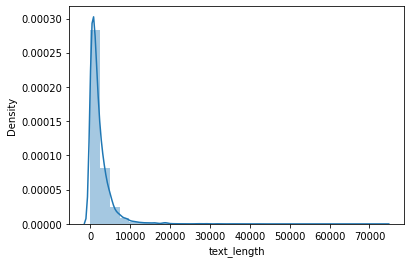

In [76]:
sns.distplot(a=fake_newss['text_length'],bins=30)

In [77]:
tfidf_vec = TfidfVectorizer(max_df=0.5,stop_words='english')

In [78]:
test1 = df['desc']
test1_vec = vect.transform(test1)

# **Combine All Microfactors and Assess Veracity Factor**

In [79]:
prob_adj = model_lr_adj.predict_proba(test1_vec)
prob_adv = model_lr_adv.predict_proba(test1_vec)
prob_pro = model_lr_pro.predict_proba(test1_vec)


In [80]:
df2 = pd.DataFrame(prob_adj[:,1],columns={'adjective'})
df3 = pd.DataFrame(prob_adv[:,1],columns={'adverb'})
df4 = pd.DataFrame(prob_pro[:,1],columns={'contains_profanity'})

In [81]:
result_dataframe = pd.concat([df['desc'],df2,df3,df4],axis=1)

In [82]:
result_dataframe.head()

,desc,adjective,adverb,contains_profanity
0,Google confirms an algorithm updated targeted ...,0.834996,0.368229,0.058510
1,"New Jersey, United States,- This Enterprise Sp...",0.923716,0.725911,0.029189
2,"Sweet corn, earthy sun-dried tomatoes and salt...",0.842117,0.446339,0.075371
3,I start off announcing the winner(s) of the Sq...,0.897336,0.516404,0.050332
4,Google finished the rollout for the November s...,0.865768,0.450800,0.058880


In [83]:
accur = [ 0.93, 0.98, 0.95] # using the (normalized) accuracy as weigths

w = [float(i)/sum(accur) for i in accur]
sumW = 0
prob = []
prob.append(w[0] * result_dataframe['adjective'])
sumW += w[0]
prob.append(w[1] * result_dataframe['adverb'])
sumW += w[1]
prob.append(w[2] * result_dataframe['contains_profanity'])
sumW += w[2]
probTotal = sum(prob[0:len(prob)]) / sumW
result_dataframe['spam_final_Score'] = probTotal

In [84]:
result_dataframe['spam_final_Score'] = result_dataframe['spam_final_Score'].round(decimals = 3)

In [85]:
result_dataframe

,desc,adjective,adverb,contains_profanity,spam_final_Score
0,Google confirms an algorithm updated targeted ...,0.834996,0.368229,0.058510,0.417
1,"New Jersey, United States,- This Enterprise Sp...",0.923716,0.725911,0.029189,0.559
2,"Sweet corn, earthy sun-dried tomatoes and salt...",0.842117,0.446339,0.075371,0.452
3,I start off announcing the winner(s) of the Sq...,0.897336,0.516404,0.050332,0.485
4,Google finished the rollout for the November s...,0.865768,0.450800,0.058880,0.456
...,...,...,...,...,...
295,"Over the past few years, some malicious actors...",0.863168,0.489213,0.068262,0.471
296,Some weeks ago a critical unauthenticated priv...,0.864043,0.508743,0.058433,0.475
297,"L&L Hawaiian Barbecue, the popular Hawaiian-st...",0.867431,0.460347,0.049450,0.456
298,"CAPE GIRARDEAU, Mo. (KFVS) - Are you getting s...",0.869410,0.445460,0.061178,0.456


In [86]:
result_dataframe.drop(['adjective','adverb','contains_profanity'], axis = 1,inplace = True)

In [87]:
result_dataframe.head()

,desc,spam_final_Score
0,Google confirms an algorithm updated targeted ...,0.417
1,"New Jersey, United States,- This Enterprise Sp...",0.559
2,"Sweet corn, earthy sun-dried tomatoes and salt...",0.452
3,I start off announcing the winner(s) of the Sq...,0.485
4,Google finished the rollout for the November s...,0.456


In [88]:
result_dataframe.rename(columns={"desc": "Article"},inplace = True)

In [89]:
pip install plotly pandas

In [90]:
import plotly.graph_objects as go

In [91]:
fig1 = go.Figure(data=[go.Table(
  columnorder = [1,2],
  columnwidth = [300,80],
  header = dict(values=list(result_dataframe.columns)),
  cells=dict(values=[result_dataframe["Article"], result_dataframe['spam_final_Score']],height=70))
])
fig1.show()